In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from sklearn import manifold
from cs_systems.lstm_vae import VariationalRecurrentAutoEncoder

In [93]:
def create_ctable(characters):
    def encode(sequence):
        encoded_s = []
        for sc in sequence:
            enc = [1 if sc == c else 0 for i, c in enumerate(characters)]
            encoded_s.append(enc)

        return encoded_s

    def decode(sequence, calc_argmax=True):
        if calc_argmax:
            sequence = sequence.argmax(axis=-1)

        return [characters[i] for i in sequence]

    return encode, decode


def vectorize(data, encode):
    return np.array([encode(sequence) for sequence in data], dtype='float32')


def generate_tonal_data(size, timesteps):
    samples = []
    samples_reverse = []

    diatonic = np.array([0, 2, 4, 5, 7, 9, 11])
    characters = np.array([str(i) for i in range(24,46)])
    
    seen = []
    while len(samples) < size:
        root = random.randint(0, len(characters) - 1)
        diatonic_indices = (diatonic + root) % 11
        diatonic_characters = characters[diatonic_indices]

        notes = [random.randint(0, len(diatonic_characters) - 1) for _ in range(timesteps)]
        tune = [diatonic_characters[i] for i in notes]
        tune_as_string = "".join(tune)

        if tune_as_string in seen:
            continue
        else:
            seen.append(tune_as_string)

        samples.append(tune)
        samples_reverse.append(tune[::-1])

    return samples, samples_reverse

def generate_atonal_data(size, timesteps):
    samples = []
    samples_reverse = []
    # -- one octave + equal amount of rests. 50/50 chance of rest?
    characters = [str(i) for i in range(24, 36)] 
    seen = []
    while len(samples) < size:
        notes = [random.randint(0, len(characters) - 1) for _ in range(timesteps)]
        tune = [characters[i] for i in notes]
        tune_as_string = "".join(tune)

        if tune_as_string in seen:
            continue
        else:
            seen.append(tune_as_string)

        samples.append(tune)
        samples_reverse.append(tune[::-1])

    return samples, samples_reverse

In [111]:
characters = [' '] + [str(i) for i in range(24, 36)]
encode, decode = create_ctable(characters)

timesteps = 10
hidden_dim = 128
latent_dim = 32

atonal_x, atonal_x_reverse = generate_atonal_data(10000, timesteps)
tonal_x, tonal_x_reverse = generate_tonal_data(10000, timesteps)

x_reverse = vectorize(atonal_x_reverse + tonal_x_reverse, encode)
x = vectorize(atonal_x + tonal_x, encode)

y = np.append(np.zeros(10000), np.ones(10000))
print(x_reverse.shape, x.shape, y.shape)

(20000, 10, 13) (20000, 10, 13) (20000,)


In [112]:
vae = VariationalRecurrentAutoEncoder(timesteps, len(characters), hidden_dim, latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss='categorical_crossentropy')

In [113]:
history = vae.fit(x_reverse, x, epochs=25, batch_size=128)

Train on 20000 samples
Epoch 1/25
20000/20000 [==============================] - 8s 380us/sample - loss: 2.3301
Epoch 2/25
20000/20000 [==============================] - 6s 282us/sample - loss: 2.1301
Epoch 3/25
20000/20000 [==============================] - 6s 293us/sample - loss: 2.0188
Epoch 4/25
20000/20000 [==============================] - 6s 291us/sample - loss: 1.9405
Epoch 5/25
20000/20000 [==============================] - 6s 292us/sample - loss: 1.8822
Epoch 6/25
20000/20000 [==============================] - 6s 285us/sample - loss: 1.8287
Epoch 7/25
20000/20000 [==============================] - 6s 280us/sample - loss: 1.7767
Epoch 8/25
20000/20000 [==============================] - 6s 304us/sample - loss: 1.7352
Epoch 9/25
20000/20000 [==============================] - 6s 291us/sample - loss: 1.6949
Epoch 10/25
20000/20000 [==============================] - 6s 291us/sample - loss: 1.6578
Epoch 11/25
20000/20000 [==============================] - 6s 288us/sample - loss: 1.6

In [114]:
mean, logvar, z = vae.encode(x_reverse)

In [122]:
embedded_z = manifold.TSNE(n_components=2).fit_transform(mean)

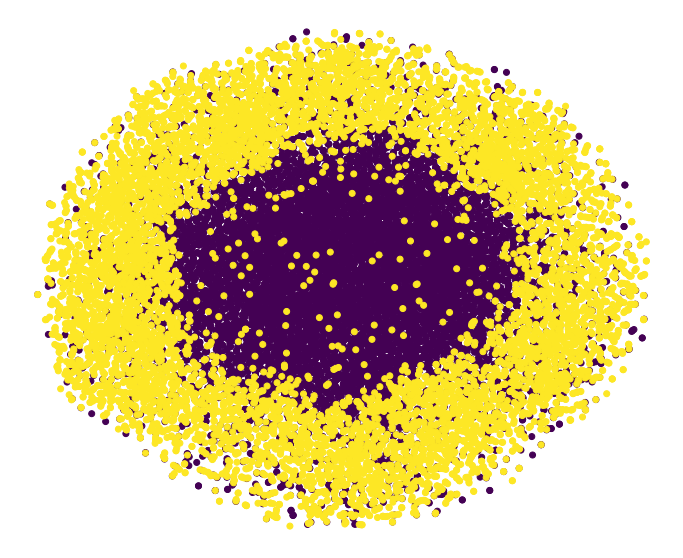

In [123]:
colors = y
fig, ax = plt.subplots(1,1, figsize=(12, 10))
sc = ax.scatter(embedded_z[:, 0], embedded_z[:, 1], c=colors)
ax.axis("off")
plt.show()

In [11]:
distances = {}

for i, x1 in enumerate(mean):
    for j, x2 in enumerate(mean):
        if i == j:
            continue

        key = tuple(sorted((i, j)))

        if key in distances:
            continue
        else:
            dist = np.linalg.norm(x1 - x2)

            # if dist < 1:
            distances[key] = dist

print(len(distances))

499500


In [12]:
sorted_dists = sorted([(distances[k], k) for i, k in enumerate(distances)], key=lambda x: x[0])
sorted_dists[:20]

[(0.0, (280, 934)),
 (0.0, (379, 464)),
 (1.441317, (278, 836)),
 (1.4486346, (69, 959)),
 (1.5193075, (69, 531)),
 (1.5417305, (863, 975)),
 (1.5735266, (479, 853)),
 (1.6224254, (647, 813)),
 (1.6327704, (141, 959)),
 (1.6516489, (14, 372)),
 (1.6656294, (108, 148)),
 (1.6818402, (669, 963)),
 (1.7296828, (836, 957)),
 (1.759135, (432, 667)),
 (1.7657632, (69, 94)),
 (1.768697, (230, 537)),
 (1.828142, (94, 959)),
 (1.8568339, (108, 538)),
 (1.8608366, (495, 844)),
 (1.8777226, (151, 804))]

In [20]:
for dist, (i, j) in sorted_dists[:20]:
    print(f"{'-' * 25} {i}-{j} {'-' * 25}")
    print(decode(x[i]))
    print(decode(x[j]))
    print()

------------------------- 280-934 -------------------------
[' ', ' ', ' ', ' ', ' ', ' ', '30', ' ', '25', ' ']
[' ', ' ', ' ', ' ', ' ', ' ', '30', ' ', '25', ' ']

------------------------- 379-464 -------------------------
['29', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
['29', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

------------------------- 278-836 -------------------------
[' ', ' ', ' ', '30', '35', '25', ' ', ' ', ' ', ' ']
[' ', ' ', ' ', '30', '35', ' ', ' ', ' ', ' ', ' ']

------------------------- 69-959 -------------------------
[' ', '32', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', ' ', '32', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

------------------------- 69-531 -------------------------
[' ', '32', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
[' ', '32', ' ', ' ', ' ', ' ', '26', ' ', ' ', ' ']

------------------------- 863-975 -------------------------
[' ', '25', ' ', ' ', ' ', ' ', ' ', '30', ' ', '32']
[' ', ' ', ' ', ' ', '25', ' ', ' ', '30', ' ', '32']

--